In [99]:
import os
os.chdir('D:\\Gnan\\DA\\KMU\\Prediction-COVID-19')
from utils import *

import scipy.stats as stats
from scipy.stats import shapiro
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from sklearn.linear_model import LinearRegression
import seaborn as sns

import statsmodels.api as sm
sns.set_theme(style = 'darkgrid')
from colorama import Fore, Back, Style

import warnings
warnings.filterwarnings('ignore')

In [100]:
def g_shapiro(name, x):
    print(f'{name} 검정 통계량 :', shapiro(x)[0], f', {name} p-value :', shapiro(x)[1])
    if shapiro(x)[1] >= 0.05:
        print(f'{name}은 정규성을 만족')
    else:
        print(f'{name}은 정규성을 만족하지 않음')
    
def g_corr_heatmap(df):
    corr_pearson = df.corr(method = 'pearson')
    corr_spearman = df.corr(method = 'spearman')
    corr_kendall = df.corr(method = 'kendall')
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    sns.heatmap(corr_pearson, annot=True, cmap='coolwarm', ax = axes[0])
    axes[0].set_title('Pearson Correlation')
    sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', ax = axes[1])
    axes[1].set_title('Spearman Correlation')
    sns.heatmap(corr_kendall, annot=True, cmap='coolwarm', ax = axes[2])
    axes[2].set_title('Kendall Correlation')
    
    plt.tight_layout()
    plt.show()
    
def g_corr(df, y):
    corr_method_list = ['Pearson', 'Spearman', 'Kendall']
    method_num = 0

    for col in df.columns[2:]:
        x = df[col]
        print(Fore.MAGENTA + col + Fore.BLACK + '와 Difference의 상관 분석')
        print('')
        method_num = 0
        for method in corr_method_list:

            if method_num == 0:
                corr_ = pearsonr
            elif method_num == 1:
                corr_ = spearmanr
            else:
                corr_ = kendalltau


            corr_coef, p_value = corr_(x, y)
            print(Fore.BLACK + f"    {method} correlation coefficient:", corr_coef)
            print(Fore.BLACK + "    p-value:", p_value)
            if p_value < 0.05:
                print(Fore.RED + '    귀무가설 기각, 상관계수는 유의함')
            else:
                print(Fore.BLUE + '    귀무가설 채택, 상관계수는 유의하지 않음')
            print('')

            method_num += 1
            
def g_OLS(df, y, col_list):
    lr = LinearRegression()
    
    for col in col_list:
        x = df[col]
        lr.fit(x.values.reshape(-1, 1), y.values.reshape(-1, 1))
        y2 = lr.coef_[0]*x + lr.intercept_
        sns.scatterplot(x = x, y = y, data = df)
        sns.lineplot(x = x, y = y2, color = 'red')
        plt.show()

        print(f'y = {lr.coef_[0][0]:.4f}x + {lr.intercept_[0]:.4f}')
        print('')
        
        results = sm.OLS(y, sm.add_constant(df[col])).fit()
        print(results.summary())
        
def g_loess(df, y, col_list):
    
    for col in col_list:
        print(col)
        x = df[col]
        lowess = sm.nonparametric.lowess(y, x)

        sns.scatterplot(x = x, y = y, data = df)
        sns.lineplot(x = lowess[:, 0], y = lowess[:, 1], color = 'red')
        plt.show()

        lowess_summary = sm.OLS(lowess[:, 1], sm.add_constant(lowess[:, 0])).fit().summary()
        print(lowess_summary)
        print('')

# Infected

In [101]:
key = 'Infected'
var_list = ['up1', 'up2', 'down1', 'down2']
city_list = ['강원', '경기', '경남', '경북', '광주', '대구', 
          '대전', '부산', '서울', '세종', '울산', '인천',
          '전남', '전북', '제주', '충남', '충북']

path = f'Data/Predicted/Stricgency/{key}/valid_score.pkl'
with open(path, 'rb') as f:
    dic_valid_score = pickle.load(f)
    
df_cities = pd.read_csv('Data/Statistics/Correlation.csv', encoding = 'cp949')

In [102]:
dic_valid = {}
for var in var_list:
    valid_list = []
    for city in city_list:
        valid_list.append([city, dic_valid_score[var][city]['best_model'][2]])
        
    dic_valid[var] = valid_list
    
dic_valid.keys()

dic_df = {}
for var in var_list:
    dic_df[var] = pd.concat([pd.DataFrame(dic_valid[var], columns = ['City', 'Difference']), df_cities.iloc[:, 1:]], axis = 1)
    

Population 검정 통계량 : 0.6380905508995056 , Population p-value : 2.49221902777208e-05
Population은 정규성을 만족하지 않음


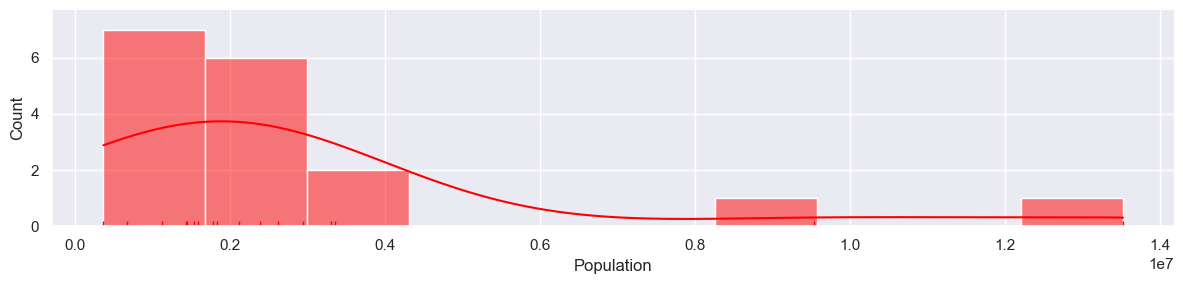

Area 검정 통계량 : 0.8241554498672485 , Area p-value : 0.004435380920767784
Area은 정규성을 만족하지 않음


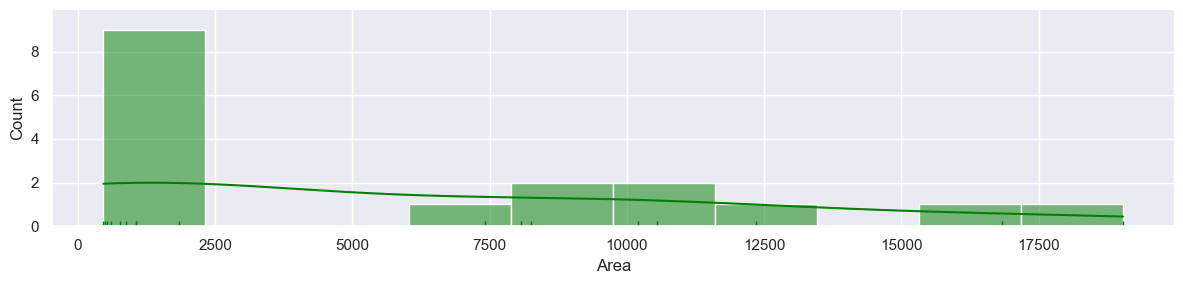

Population density 검정 통계량 : 0.5482955574989319 , Population density p-value : 3.4245413189637475e-06
Population density은 정규성을 만족하지 않음


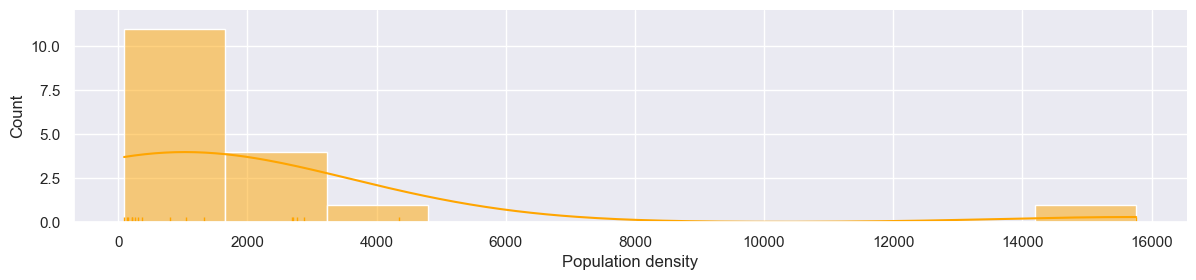

Elderly Ratio 검정 통계량 : 0.9757487773895264 , Elderly Ratio p-value : 0.9088438749313354
Elderly Ratio은 정규성을 만족


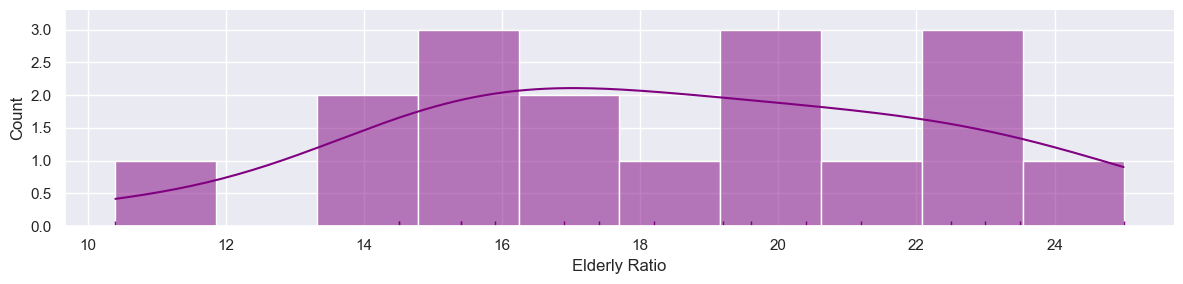

In [103]:
i = 0
df = dic_df['up1']
color_list = ['red', 'green', 'orange', 'purple']
for col in df.columns[2:]:
    g_shapiro(col, df[col])
    sns.displot(df[col], color = color_list[i], kde = True, rug = True, aspect = 4, height = 3, bins = 10)
    plt.show()
    i += 1

## up1

In [104]:
df = dic_df['up1']
df.head()

,City,Difference,Population,Area,Population density,Elderly Ratio
0,강원,-317.738403,1539277,16830,91.460309,22.5
1,경기,-2097.083984,13527299,10197,1326.595960,14.5
2,경남,-210.244385,3311631,10542,314.136881,19.2
3,경북,-35.130127,2622174,19035,137.755398,23.5
4,광주,-162.626343,1440908,501,2876.063872,15.4


### 정규성 검정

Difference 검정 통계량 : 0.6780420541763306 , Difference p-value : 6.589372060261667e-05
Difference은 정규성을 만족하지 않음


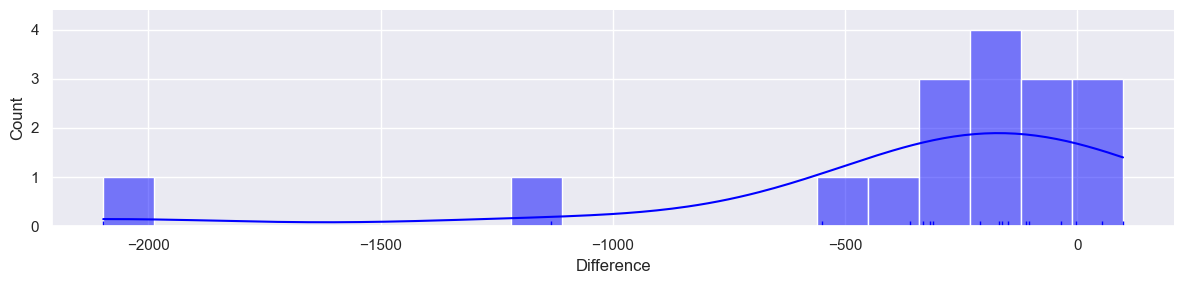

In [105]:
g_shapiro('Difference', df['Difference'])
sns.displot(df['Difference'], color = 'blue', kde = True, rug = True, aspect = 4, height = 3, bins = 20)
plt.show()

## 상관분석

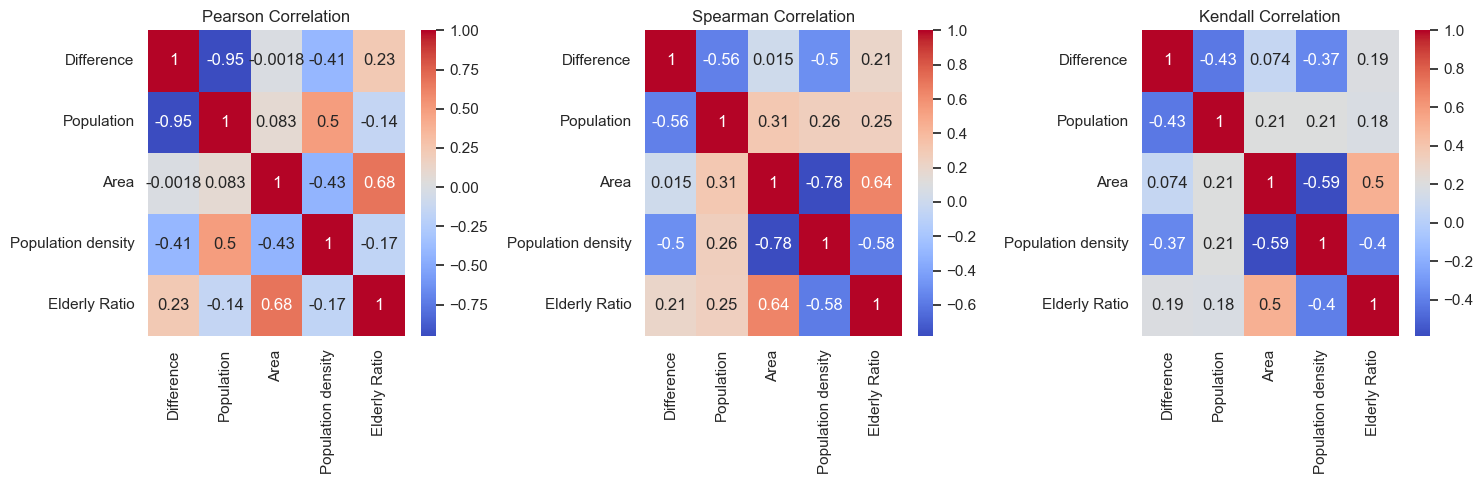

In [106]:
g_corr_heatmap(df)

In [107]:
y = df['Difference']
g_corr(df, y)

Population와 Difference의 상관 분석

    Pearson correlation coefficient: -0.9504903152098916
    p-value: 5.155543281441023e-09
    귀무가설 기각, 상관계수는 유의함

    Spearman correlation coefficient: -0.5637254901960785
    p-value: 0.01843498951569228
    귀무가설 기각, 상관계수는 유의함

    Kendall correlation coefficient: -0.4264705882352941
    p-value: 0.017119110549244844
    귀무가설 기각, 상관계수는 유의함

Area와 Difference의 상관 분석

    Pearson correlation coefficient: -0.0018341473793498236
    p-value: 0.9944257833113284
    귀무가설 채택, 상관계수는 유의하지 않음

    Spearman correlation coefficient: 0.014705882352941176
    p-value: 0.9553274855428822
    귀무가설 채택, 상관계수는 유의하지 않음

    Kendall correlation coefficient: 0.07352941176470587
    p-value: 0.7150317752938318
    귀무가설 채택, 상관계수는 유의하지 않음

Population density와 Difference의 상관 분석

    Pearson correlation coefficient: -0.41302056798154074
    p-value: 0.09940393261613976
    귀무가설 채택, 상관계수는 유의하지 않음

    Spearman correlation coefficient: -0.502450980392157
    p-value: 0.039832967623

## 선형회귀분석

### OLS

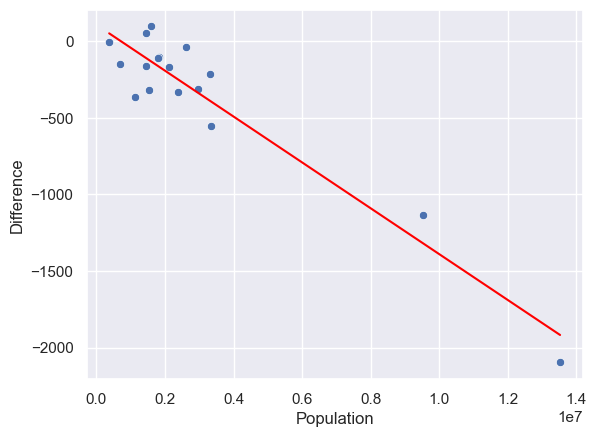

y = -0.0001x + 108.4347

                            OLS Regression Results                            
Dep. Variable:             Difference   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     140.3
Date:                Sun, 25 Jun 2023   Prob (F-statistic):           5.16e-09
Time:                        22:43:42   Log-Likelihood:                -110.46
No. Observations:                  17   AIC:                             224.9
Df Residuals:                      15   BIC:                             226.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        108.4347     5

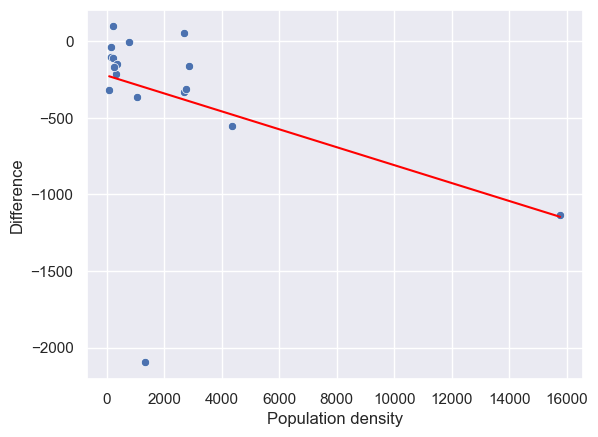

y = -0.0586x + -222.1479

                            OLS Regression Results                            
Dep. Variable:             Difference   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     3.085
Date:                Sun, 25 Jun 2023   Prob (F-statistic):             0.0994
Time:                        22:43:43   Log-Likelihood:                -128.73
No. Observations:                  17   AIC:                             261.5
Df Residuals:                      15   BIC:                             263.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const     

In [108]:
y = df['Difference']
col_list = ['Population', 'Population density']
g_OLS(df, y, col_list)

### LOESS

Population


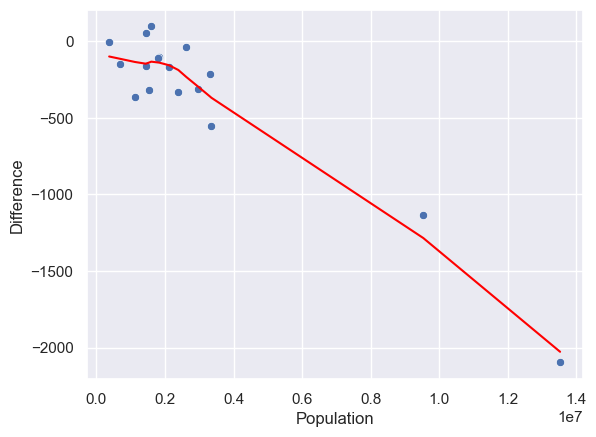

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     878.5
Date:                Sun, 25 Jun 2023   Prob (F-statistic):           9.94e-15
Time:                        22:43:43   Log-Likelihood:                -94.934
No. Observations:                  17   AIC:                             193.9
Df Residuals:                      15   BIC:                             195.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         98.7940     22.678      4.356      0.0

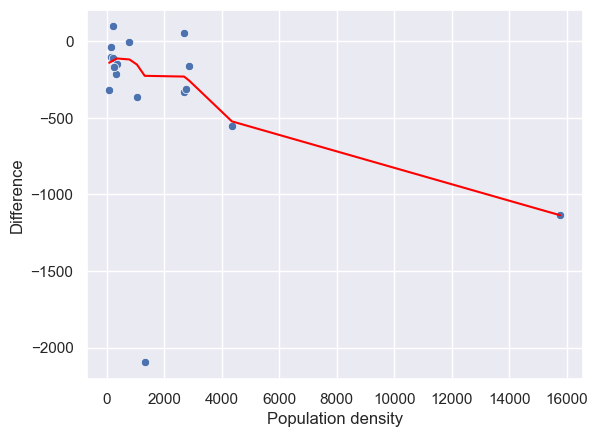

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     468.5
Date:                Sun, 25 Jun 2023   Prob (F-statistic):           1.00e-12
Time:                        22:43:43   Log-Likelihood:                -88.034
No. Observations:                  17   AIC:                             180.1
Df Residuals:                      15   BIC:                             181.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -102.2151     12.831     -7.966      0.0

In [109]:
y = df['Difference']
col_list = ['Population', 'Population density']
g_loess(df, y, col_list)

## up2

In [110]:
df = dic_df['up2']
df.head()

,City,Difference,Population,Area,Population density,Elderly Ratio
0,강원,-365.791016,1539277,16830,91.460309,22.5
1,경기,-386.203125,13527299,10197,1326.595960,14.5
2,경남,-2186.830078,3311631,10542,314.136881,19.2
3,경북,-253.751953,2622174,19035,137.755398,23.5
4,광주,-262.078125,1440908,501,2876.063872,15.4


### 정규성 검정

Difference 검정 통계량 : 0.6972388029098511 , Difference p-value : 0.00010758703137980774
Difference은 정규성을 만족하지 않음


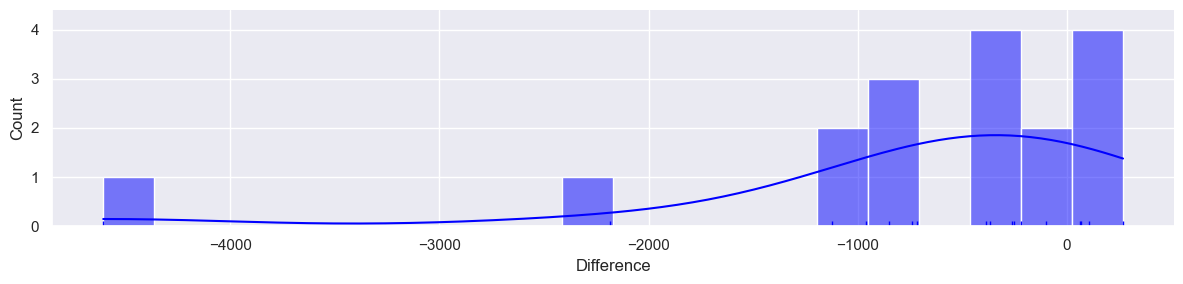

In [111]:
g_shapiro('Difference', df['Difference'])
sns.displot(df['Difference'], color = 'blue', kde = True, rug = True, aspect = 4, height = 3, bins = 20)
plt.show()

## 상관분석

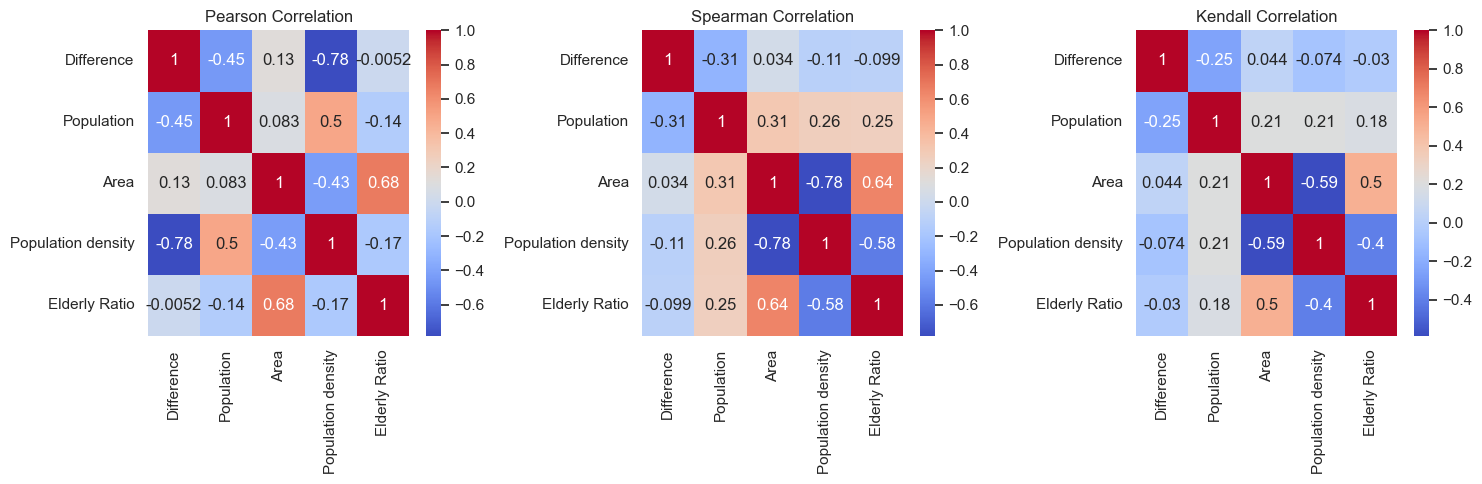

In [112]:
g_corr_heatmap(df)

In [113]:
y = df['Difference']
g_corr(df, y)

Population와 Difference의 상관 분석

    Pearson correlation coefficient: -0.45483904388993696
    p-value: 0.06659485878503642
    귀무가설 채택, 상관계수는 유의하지 않음

    Spearman correlation coefficient: -0.31127450980392163
    p-value: 0.2239239360724044
    귀무가설 채택, 상관계수는 유의하지 않음

    Kendall correlation coefficient: -0.24999999999999997
    p-value: 0.17665741934030035
    귀무가설 채택, 상관계수는 유의하지 않음

Area와 Difference의 상관 분석

    Pearson correlation coefficient: 0.12814334234938252
    p-value: 0.6240395445920556
    귀무가설 채택, 상관계수는 유의하지 않음

    Spearman correlation coefficient: 0.03431372549019608
    p-value: 0.8959808104551743
    귀무가설 채택, 상관계수는 유의하지 않음

    Kendall correlation coefficient: 0.044117647058823525
    p-value: 0.8393415533036079
    귀무가설 채택, 상관계수는 유의하지 않음

Population density와 Difference의 상관 분석

    Pearson correlation coefficient: -0.7839959799039282
    p-value: 0.0001956062965611601
    귀무가설 기각, 상관계수는 유의함

    Spearman correlation coefficient: -0.10784313725490197
    p-value: 0.68035

### OLS

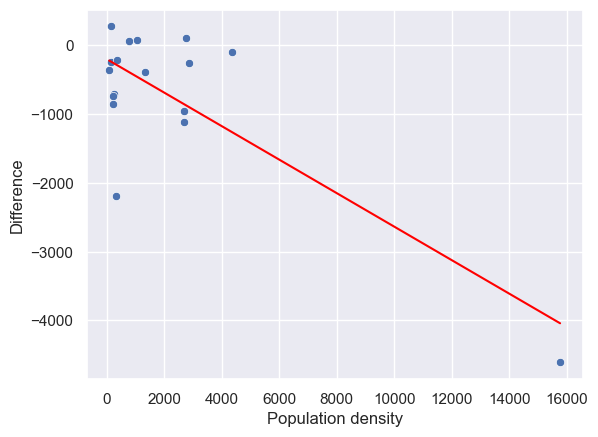

y = -0.2434x + -204.7915

                            OLS Regression Results                            
Dep. Variable:             Difference   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     23.93
Date:                Sun, 25 Jun 2023   Prob (F-statistic):           0.000196
Time:                        22:43:45   Log-Likelihood:                -135.52
No. Observations:                  17   AIC:                             275.0
Df Residuals:                      15   BIC:                             276.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const     

In [114]:
y = df['Difference']
col_list = ['Population density']
g_OLS(df, y, col_list)

### LOESS

Population density


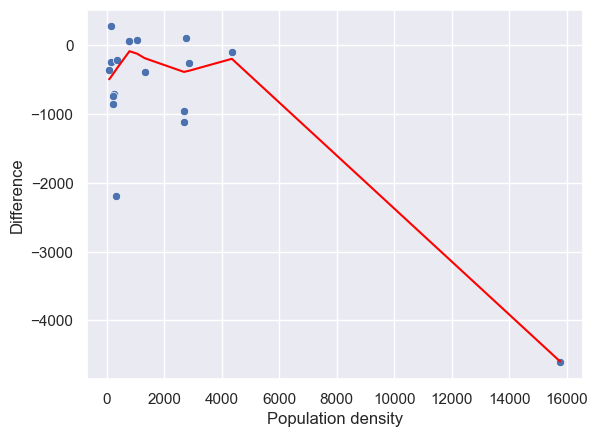

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     80.50
Date:                Sun, 25 Jun 2023   Prob (F-statistic):           2.04e-07
Time:                        22:43:45   Log-Likelihood:                -125.92
No. Observations:                  17   AIC:                             255.8
Df Residuals:                      15   BIC:                             257.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -58.7353    119.184     -0.493      0.6

In [115]:
y = df['Difference']
col_list = ['Population density']
g_loess(df, y, col_list)

## down1

In [116]:
df = dic_df['down1']
df.head()

,City,Difference,Population,Area,Population density,Elderly Ratio
0,강원,-97.258789,1539277,16830,91.460309,22.5
1,경기,-434.109375,13527299,10197,1326.595960,14.5
2,경남,113.291992,3311631,10542,314.136881,19.2
3,경북,-34.138672,2622174,19035,137.755398,23.5
4,광주,-23.846436,1440908,501,2876.063872,15.4


### 정규성 검정

Difference 검정 통계량 : 0.7420974969863892 , Difference p-value : 0.00036148852086625993
Difference은 정규성을 만족하지 않음


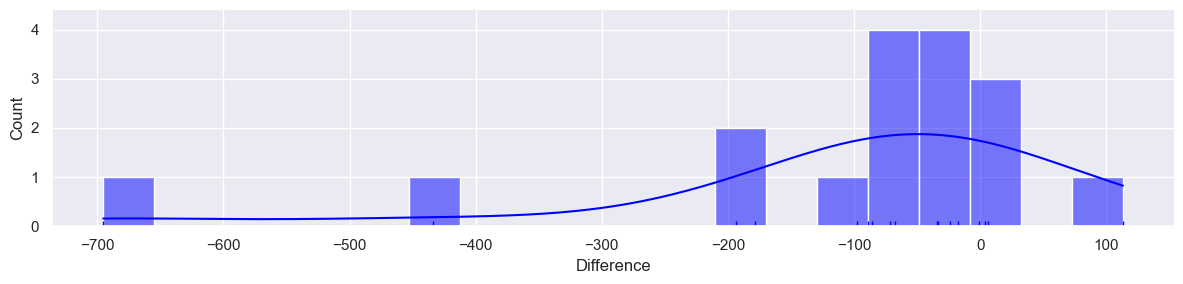

In [117]:
g_shapiro('Difference', df['Difference'])
sns.displot(df['Difference'], color = 'blue', kde = True, rug = True, aspect = 4, height = 3, bins = 20)
plt.show()

## 상관분석

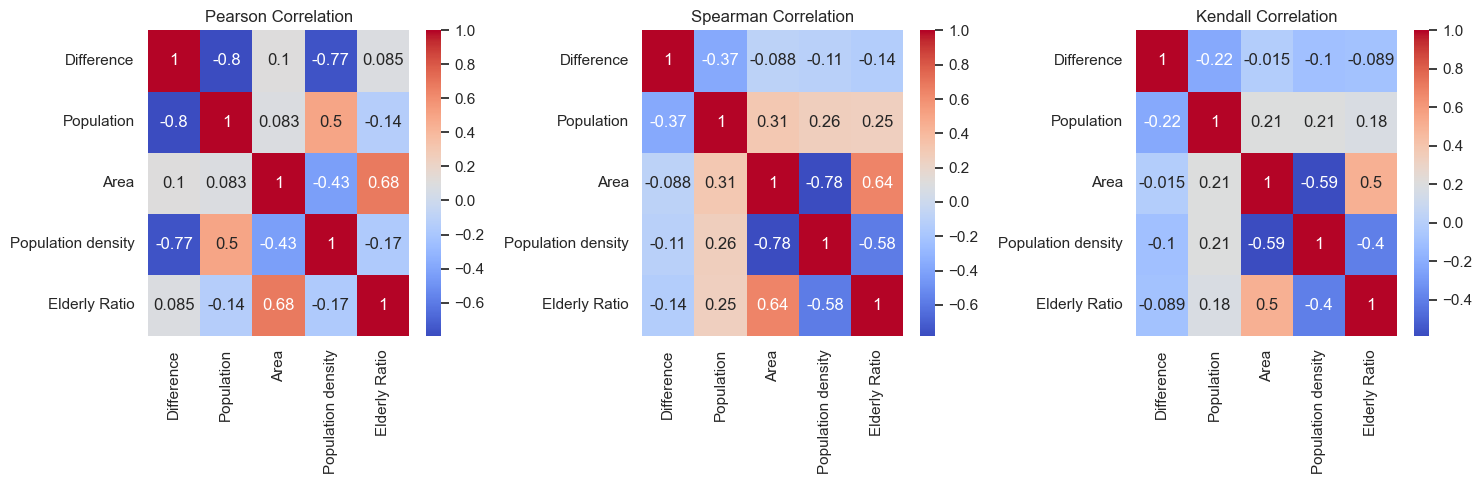

In [118]:
g_corr_heatmap(df)

In [119]:
y = df['Difference']
g_corr(df, y)

Population와 Difference의 상관 분석

    Pearson correlation coefficient: -0.7970826269341317
    p-value: 0.0001275292116580153
    귀무가설 기각, 상관계수는 유의함

    Spearman correlation coefficient: -0.37009803921568635
    p-value: 0.14367547273095144
    귀무가설 채택, 상관계수는 유의하지 않음

    Kendall correlation coefficient: -0.2205882352941176
    p-value: 0.23617204064651248
    귀무가설 채택, 상관계수는 유의하지 않음

Area와 Difference의 상관 분석

    Pearson correlation coefficient: 0.10194249609963929
    p-value: 0.6970387707556147
    귀무가설 채택, 상관계수는 유의하지 않음

    Spearman correlation coefficient: -0.08823529411764706
    p-value: 0.7363051515421215
    귀무가설 채택, 상관계수는 유의하지 않음

    Kendall correlation coefficient: -0.014705882352941175
    p-value: 0.9676638168395322
    귀무가설 채택, 상관계수는 유의하지 않음

Population density와 Difference의 상관 분석

    Pearson correlation coefficient: -0.7664748526656562
    p-value: 0.0003322279637518887
    귀무가설 기각, 상관계수는 유의함

    Spearman correlation coefficient: -0.11274509803921569
    p-value: 0.666592

## 선형회귀분석

### OLS

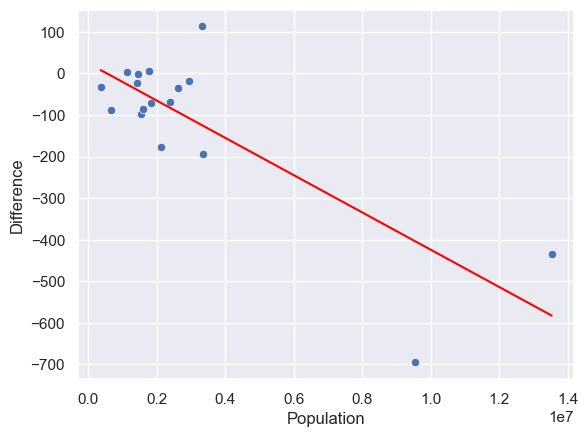

y = -0.0000x + 24.6472

                            OLS Regression Results                            
Dep. Variable:             Difference   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     26.13
Date:                Sun, 25 Jun 2023   Prob (F-statistic):           0.000128
Time:                        22:43:47   Log-Likelihood:                -104.26
No. Observations:                  17   AIC:                             212.5
Df Residuals:                      15   BIC:                             214.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.6472     39

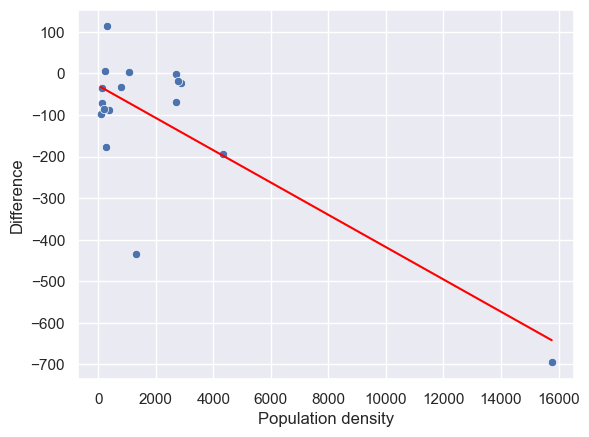

y = -0.0389x + -29.1967

                            OLS Regression Results                            
Dep. Variable:             Difference   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     21.36
Date:                Sun, 25 Jun 2023   Prob (F-statistic):           0.000332
Time:                        22:43:47   Log-Likelihood:                -105.31
No. Observations:                  17   AIC:                             214.6
Df Residuals:                      15   BIC:                             216.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const      

In [120]:
y = df['Difference']
col_list = ['Population', 'Population density']
g_OLS(df, y, col_list)

### LOESS

Population


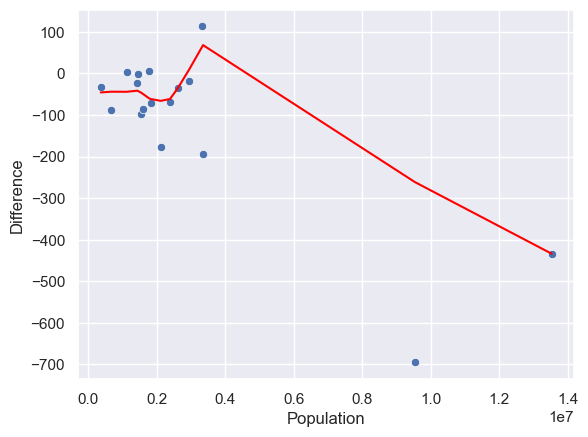

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     39.26
Date:                Sun, 25 Jun 2023   Prob (F-statistic):           1.51e-05
Time:                        22:43:47   Log-Likelihood:                -93.591
No. Observations:                  17   AIC:                             191.2
Df Residuals:                      15   BIC:                             192.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.4956     20.955      1.026      0.3

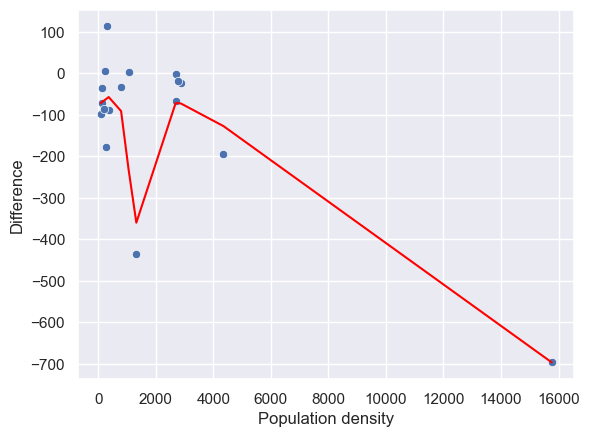

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     36.86
Date:                Sun, 25 Jun 2023   Prob (F-statistic):           2.14e-05
Time:                        22:43:47   Log-Likelihood:                -99.802
No. Observations:                  17   AIC:                             203.6
Df Residuals:                      15   BIC:                             205.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -57.4648     25.640     -2.241      0.0

In [121]:
y = df['Difference']
col_list = ['Population', 'Population density']
g_loess(df, y, col_list)

## down2

In [122]:
df = dic_df['down2']
df.head()

,City,Difference,Population,Area,Population density,Elderly Ratio
0,강원,-21161.4375,1539277,16830,91.460309,22.5
1,경기,-102705.5000,13527299,10197,1326.595960,14.5
2,경남,-40362.3125,3311631,10542,314.136881,19.2
3,경북,-60530.7500,2622174,19035,137.755398,23.5
4,광주,-30605.0625,1440908,501,2876.063872,15.4


### 정규성 검정

Difference 검정 통계량 : 0.8798505067825317 , Difference p-value : 0.03162018954753876
Difference은 정규성을 만족하지 않음


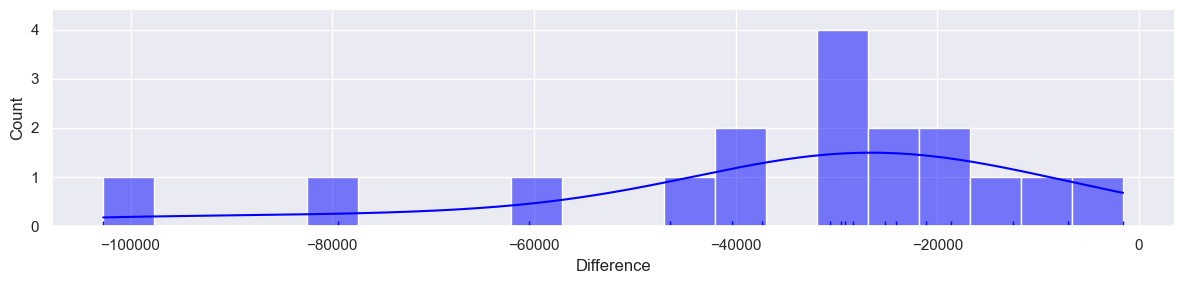

In [123]:
g_shapiro('Difference', df['Difference'])
sns.displot(df['Difference'], color = 'blue', kde = True, rug = True, aspect = 4, height = 3, bins = 20)
plt.show()

## 상관분석

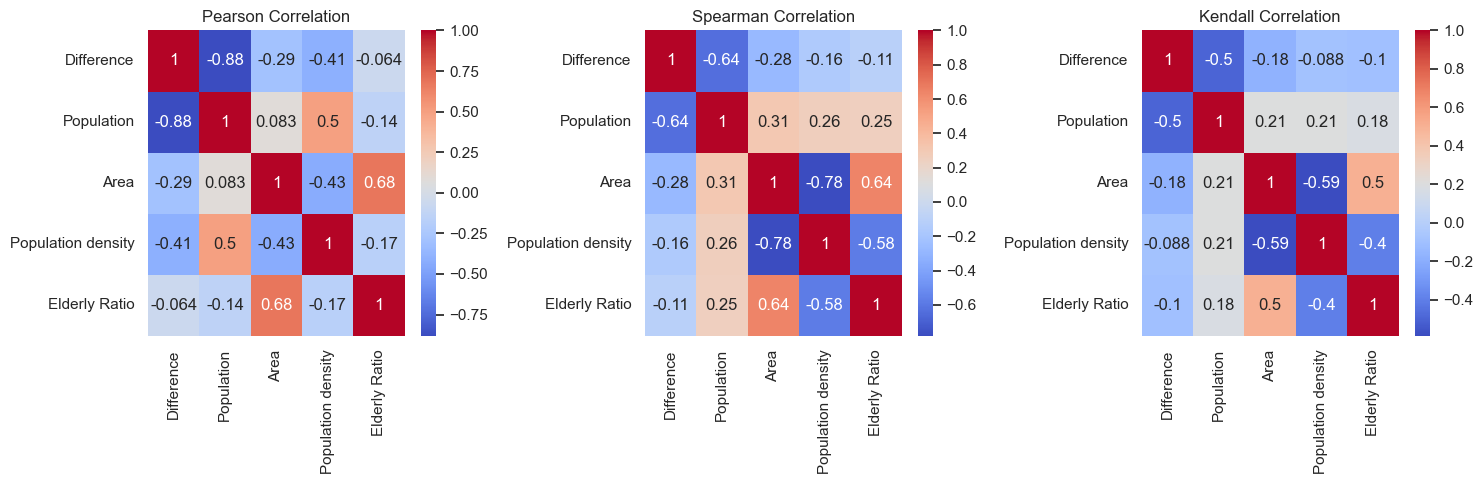

In [124]:
g_corr_heatmap(df)

In [125]:
y = df['Difference']
g_corr(df, y)

Population와 Difference의 상관 분석

    Pearson correlation coefficient: -0.8824759841842295
    p-value: 2.756580367927069e-06
    귀무가설 기각, 상관계수는 유의함

    Spearman correlation coefficient: -0.6421568627450981
    p-value: 0.005445541252413795
    귀무가설 기각, 상관계수는 유의함

    Kendall correlation coefficient: -0.49999999999999994
    p-value: 0.004507537046975066
    귀무가설 기각, 상관계수는 유의함

Area와 Difference의 상관 분석

    Pearson correlation coefficient: -0.2889462757058896
    p-value: 0.2606675714088359
    귀무가설 채택, 상관계수는 유의하지 않음

    Spearman correlation coefficient: -0.27696078431372556
    p-value: 0.281843162514077
    귀무가설 채택, 상관계수는 유의하지 않음

    Kendall correlation coefficient: -0.1764705882352941
    p-value: 0.34884640290128766
    귀무가설 채택, 상관계수는 유의하지 않음

Population density와 Difference의 상관 분석

    Pearson correlation coefficient: -0.409025681075243
    p-value: 0.1030504080634609
    귀무가설 채택, 상관계수는 유의하지 않음

    Spearman correlation coefficient: -0.15686274509803924
    p-value: 0.54768058470293

## 선형회귀분석

### OLS

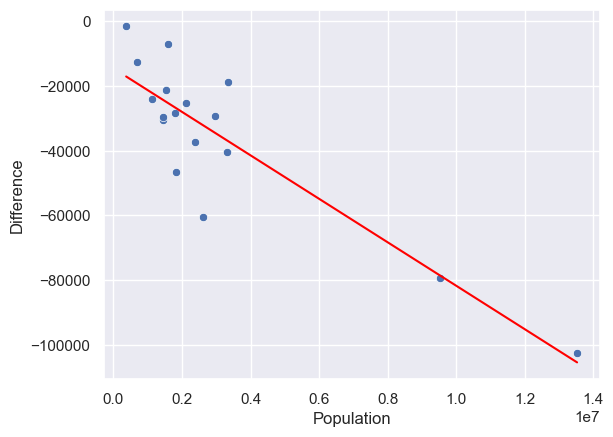

y = -0.0067x + -14596.8925

                            OLS Regression Results                            
Dep. Variable:             Difference   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     52.80
Date:                Sun, 25 Jun 2023   Prob (F-statistic):           2.76e-06
Time:                        22:43:49   Log-Likelihood:                -183.42
No. Observations:                  17   AIC:                             370.8
Df Residuals:                      15   BIC:                             372.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -1.46e+04   

In [126]:
y = df['Difference']
col_list = ['Population']
g_OLS(df, y, col_list)

### LOESS

Population


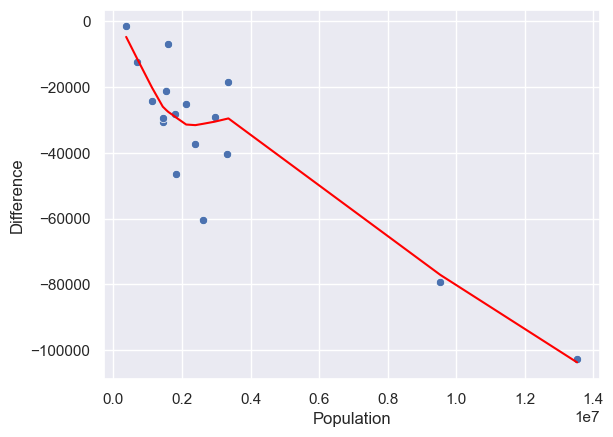

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     370.9
Date:                Sun, 25 Jun 2023   Prob (F-statistic):           5.45e-12
Time:                        22:43:49   Log-Likelihood:                -166.89
No. Observations:                  17   AIC:                             337.8
Df Residuals:                      15   BIC:                             339.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.285e+04   1562.204     -8.224      0.0

In [127]:
y = df['Difference']
col_list = ['Population']
g_loess(df, y, col_list)

# SIR

In [128]:
key = 'SIR'
var_list = ['up1', 'up2', 'down1', 'down2']
city_list = ['강원', '경기', '경남', '경북', '광주', '대구', 
          '대전', '부산', '서울', '세종', '울산', '인천',
          '전남', '전북', '제주', '충남', '충북']

path = f'Data/Predicted/Stricgency/{key}/valid_score.pkl'
with open(path, 'rb') as f:
    dic_valid_score = pickle.load(f)
    
df_cities = pd.read_csv('Data/Statistics/Correlation.csv', encoding = 'cp949')

In [129]:
dic_valid = {}
for var in var_list:
    valid_list = []
    for city in city_list:
        valid_list.append([city, dic_valid_score[var][city]['best_model'][2]])
        
    dic_valid[var] = valid_list
    
dic_valid.keys()

dic_df = {}
for var in var_list:
    dic_df[var] = pd.concat([pd.DataFrame(dic_valid[var], columns = ['City', 'Difference']), df_cities.iloc[:, 1:]], axis = 1)
    

## up1

In [130]:
df = dic_df['up1']
df.head()

,City,Difference,Population,Area,Population density,Elderly Ratio
0,강원,-840.016531,1539277,16830,91.460309,22.5
1,경기,-690.558472,13527299,10197,1326.595960,14.5
2,경남,-454.229738,3311631,10542,314.136881,19.2
3,경북,-576.652726,2622174,19035,137.755398,23.5
4,광주,-171.413400,1440908,501,2876.063872,15.4


### 정규성 검정

Difference 검정 통계량 : 0.47672581672668457 , Difference p-value : 8.272029958789062e-07
Difference은 정규성을 만족하지 않음


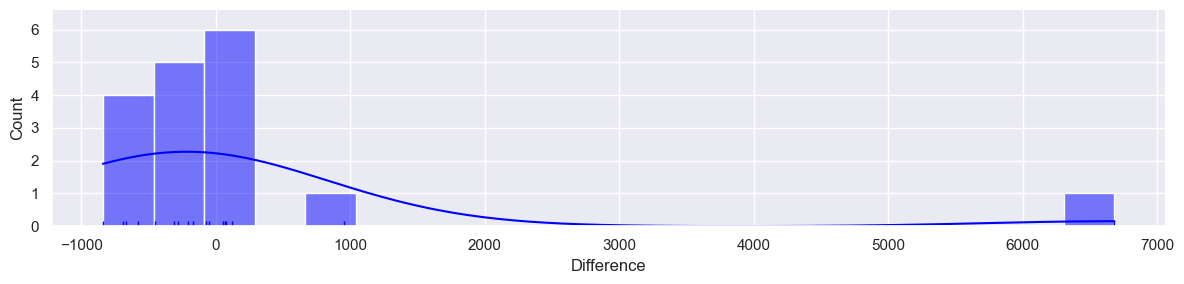

In [131]:
g_shapiro('Difference', df['Difference'])
sns.displot(df['Difference'], color = 'blue', kde = True, rug = True, aspect = 4, height = 3, bins = 20)
plt.show()

## 상관분석

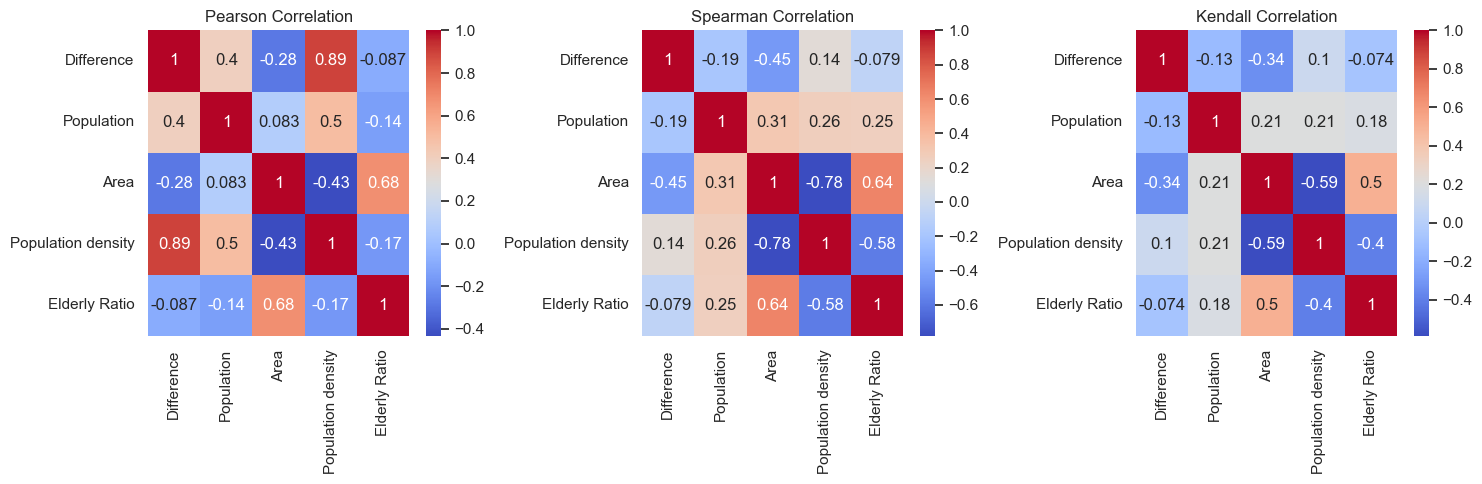

In [132]:
g_corr_heatmap(df)

In [133]:
y = df['Difference']
g_corr(df, y)

Population와 Difference의 상관 분석

    Pearson correlation coefficient: 0.40005187512569873
    p-value: 0.11158676326340466
    귀무가설 채택, 상관계수는 유의하지 않음

    Spearman correlation coefficient: -0.1936274509803922
    p-value: 0.45649692854875445
    귀무가설 채택, 상관계수는 유의하지 않음

    Kendall correlation coefficient: -0.13235294117647056
    p-value: 0.4896069682169023
    귀무가설 채택, 상관계수는 유의하지 않음

Area와 Difference의 상관 분석

    Pearson correlation coefficient: -0.2833866041524413
    p-value: 0.27036404119770496
    귀무가설 채택, 상관계수는 유의하지 않음

    Spearman correlation coefficient: -0.44852941176470595
    p-value: 0.07094643963763714
    귀무가설 채택, 상관계수는 유의하지 않음

    Kendall correlation coefficient: -0.338235294117647
    p-value: 0.06302241248726353
    귀무가설 채택, 상관계수는 유의하지 않음

Population density와 Difference의 상관 분석

    Pearson correlation coefficient: 0.8942982778261024
    p-value: 1.2896034932746811e-06
    귀무가설 기각, 상관계수는 유의함

    Spearman correlation coefficient: 0.14215686274509806
    p-value: 0.586262

## 선형회귀분석

### OLS

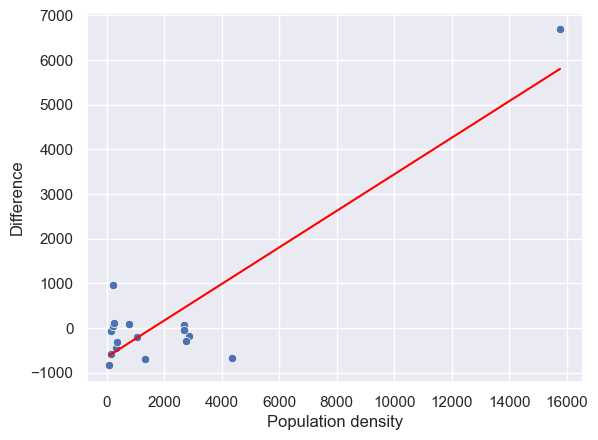

y = 0.4097x + -656.8103

                            OLS Regression Results                            
Dep. Variable:             Difference   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     59.91
Date:                Sun, 25 Jun 2023   Prob (F-statistic):           1.29e-06
Time:                        22:43:51   Log-Likelihood:                -136.57
No. Observations:                  17   AIC:                             277.1
Df Residuals:                      15   BIC:                             278.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const      

In [134]:
y = df['Difference']
col_list = ['Population density']
g_OLS(df, y, col_list)

### LOESS

Population density


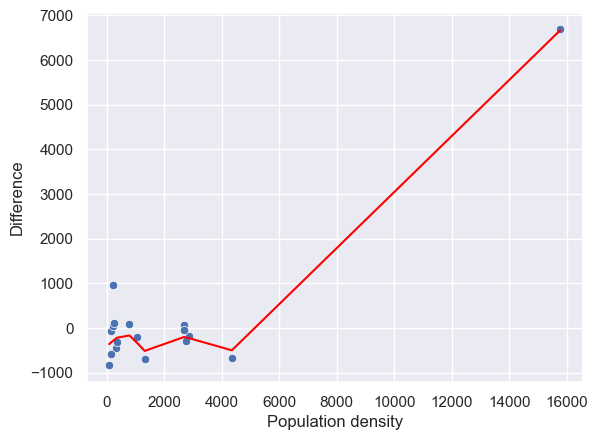

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     101.3
Date:                Sun, 25 Jun 2023   Prob (F-statistic):           4.59e-08
Time:                        22:43:51   Log-Likelihood:                -132.55
No. Observations:                  17   AIC:                             269.1
Df Residuals:                      15   BIC:                             270.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -780.1078    176.023     -4.432      0.0

In [135]:
y = df['Difference']
col_list = ['Population density']
g_loess(df, y, col_list)

## up2

In [136]:
df = dic_df['up2']
df.head()

,City,Difference,Population,Area,Population density,Elderly Ratio
0,강원,-195.712772,1539277,16830,91.460309,22.5
1,경기,-1747.511656,13527299,10197,1326.595960,14.5
2,경남,42.665465,3311631,10542,314.136881,19.2
3,경북,-68.088070,2622174,19035,137.755398,23.5
4,광주,-132.239159,1440908,501,2876.063872,15.4


### 정규성 검정

Difference 검정 통계량 : 0.8360927104949951 , Difference p-value : 0.006628171540796757
Difference은 정규성을 만족하지 않음


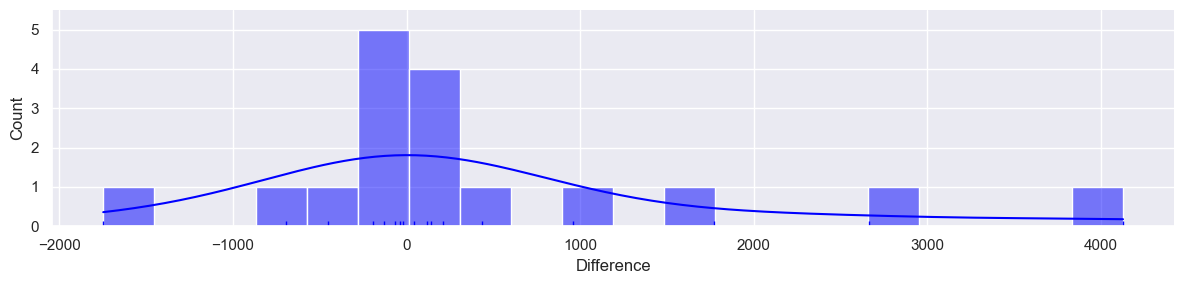

In [137]:
g_shapiro('Difference', df['Difference'])
sns.displot(df['Difference'], color = 'blue', kde = True, rug = True, aspect = 4, height = 3, bins = 20)
plt.show()

## 상관분석

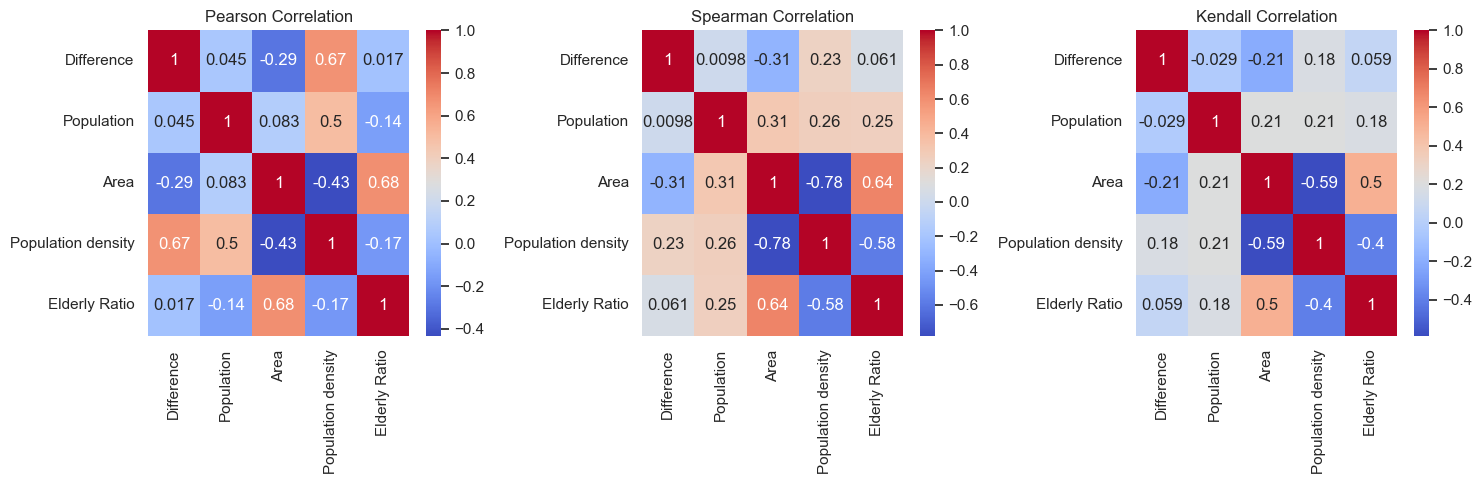

In [138]:
g_corr_heatmap(df)

In [139]:
y = df['Difference']
g_corr(df, y)

Population와 Difference의 상관 분석

    Pearson correlation coefficient: 0.045355864218558445
    p-value: 0.8627688304461029
    귀무가설 채택, 상관계수는 유의하지 않음

    Spearman correlation coefficient: 0.009803921568627453
    p-value: 0.9702105713958575
    귀무가설 채택, 상관계수는 유의하지 않음

    Kendall correlation coefficient: -0.02941176470588235
    p-value: 0.9031966906069087
    귀무가설 채택, 상관계수는 유의하지 않음

Area와 Difference의 상관 분석

    Pearson correlation coefficient: -0.2940245584561891
    p-value: 0.25200157002961854
    귀무가설 채택, 상관계수는 유의하지 않음

    Spearman correlation coefficient: -0.3088235294117647
    p-value: 0.227785653323252
    귀무가설 채택, 상관계수는 유의하지 않음

    Kendall correlation coefficient: -0.20588235294117643
    p-value: 0.27056053596407176
    귀무가설 채택, 상관계수는 유의하지 않음

Population density와 Difference의 상관 분석

    Pearson correlation coefficient: 0.6660617064027182
    p-value: 0.0035104418414332464
    귀무가설 기각, 상관계수는 유의함

    Spearman correlation coefficient: 0.2303921568627451
    p-value: 0.373664866

### OLS

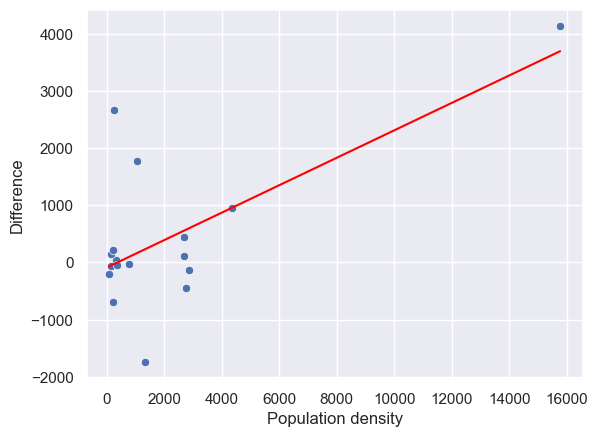

y = 0.2400x + -91.2919

                            OLS Regression Results                            
Dep. Variable:             Difference   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                     11.96
Date:                Sun, 25 Jun 2023   Prob (F-statistic):            0.00351
Time:                        22:43:53   Log-Likelihood:                -141.18
No. Observations:                  17   AIC:                             286.4
Df Residuals:                      15   BIC:                             288.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const       

In [140]:
y = df['Difference']
col_list = ['Population density']
g_OLS(df, y, col_list)

### LOESS

Population density


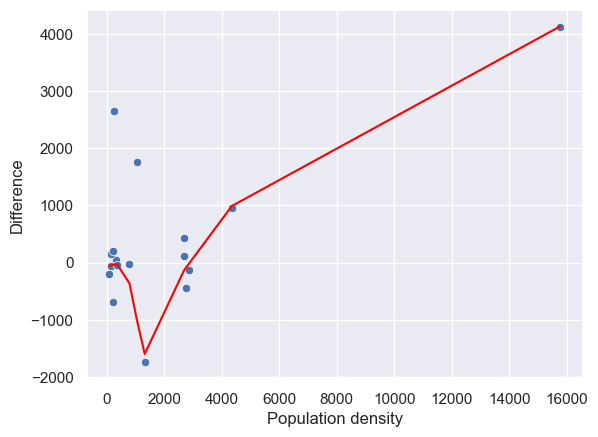

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     53.98
Date:                Sun, 25 Jun 2023   Prob (F-statistic):           2.42e-06
Time:                        22:43:53   Log-Likelihood:                -130.67
No. Observations:                  17   AIC:                             265.3
Df Residuals:                      15   BIC:                             267.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -498.0998    157.559     -3.161      0.0

In [141]:
y = df['Difference']
col_list = ['Population density']
g_loess(df, y, col_list)

## down1

In [142]:
df = dic_df['down1']
df.head()

,City,Difference,Population,Area,Population density,Elderly Ratio
0,강원,-72.795231,1539277,16830,91.460309,22.5
1,경기,585.745266,13527299,10197,1326.595960,14.5
2,경남,437.349375,3311631,10542,314.136881,19.2
3,경북,-12.828976,2622174,19035,137.755398,23.5
4,광주,184.107891,1440908,501,2876.063872,15.4


### 정규성 검정

Difference 검정 통계량 : 0.8086467385292053 , Difference p-value : 0.0026719197630882263
Difference은 정규성을 만족하지 않음


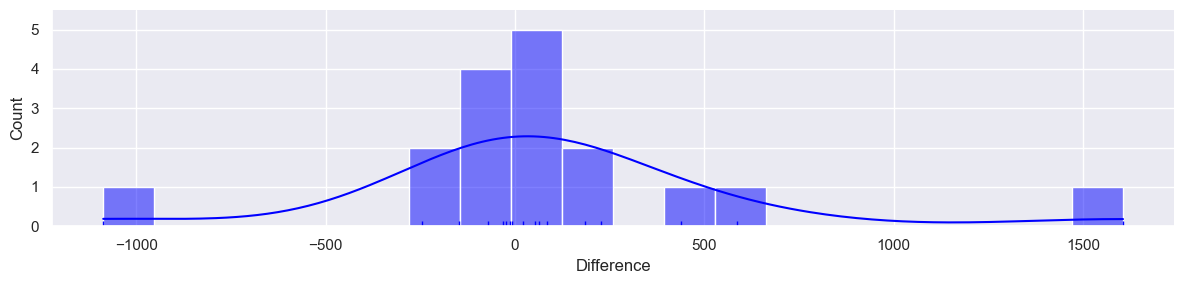

In [143]:
g_shapiro('Difference', df['Difference'])
sns.displot(df['Difference'], color = 'blue', kde = True, rug = True, aspect = 4, height = 3, bins = 20)
plt.show()

## 상관분석

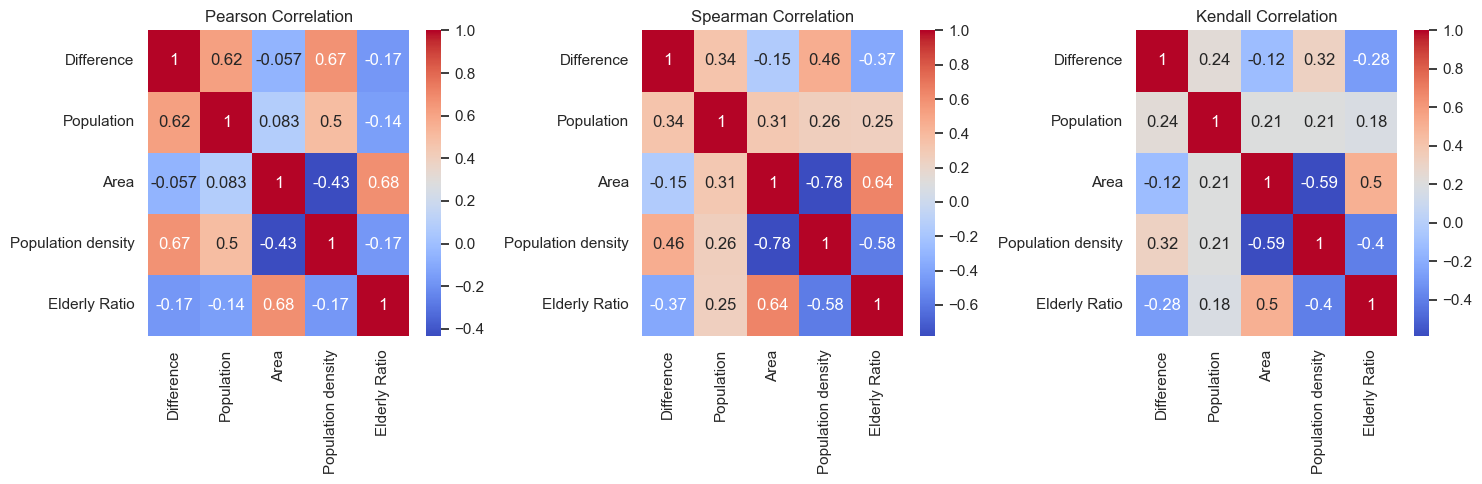

In [144]:
g_corr_heatmap(df)

In [145]:
y = df['Difference']
g_corr(df, y)

Population와 Difference의 상관 분석

    Pearson correlation coefficient: 0.6174435406459237
    p-value: 0.008269599407955462
    귀무가설 기각, 상관계수는 유의함

    Spearman correlation coefficient: 0.3382352941176471
    p-value: 0.18421188285210166
    귀무가설 채택, 상관계수는 유의하지 않음

    Kendall correlation coefficient: 0.2352941176470588
    p-value: 0.20489900152579948
    귀무가설 채택, 상관계수는 유의하지 않음

Area와 Difference의 상관 분석

    Pearson correlation coefficient: -0.05699976145362063
    p-value: 0.8279818521872018
    귀무가설 채택, 상관계수는 유의하지 않음

    Spearman correlation coefficient: -0.14950980392156862
    p-value: 0.5668307307163287
    귀무가설 채택, 상관계수는 유의하지 않음

    Kendall correlation coefficient: -0.1176470588235294
    p-value: 0.5423278567488096
    귀무가설 채택, 상관계수는 유의하지 않음

Population density와 Difference의 상관 분석

    Pearson correlation coefficient: 0.6672499656648415
    p-value: 0.003431288227742424
    귀무가설 기각, 상관계수는 유의함

    Spearman correlation coefficient: 0.4607843137254902
    p-value: 0.0626776221113285

## 선형회귀분석

### OLS

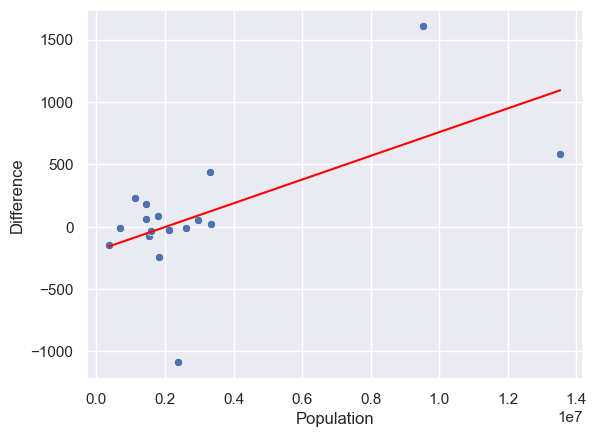

y = 0.0001x + -192.7737

                            OLS Regression Results                            
Dep. Variable:             Difference   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     9.242
Date:                Sun, 25 Jun 2023   Prob (F-statistic):            0.00827
Time:                        22:43:55   Log-Likelihood:                -125.84
No. Observations:                  17   AIC:                             255.7
Df Residuals:                      15   BIC:                             257.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -192.7737    13

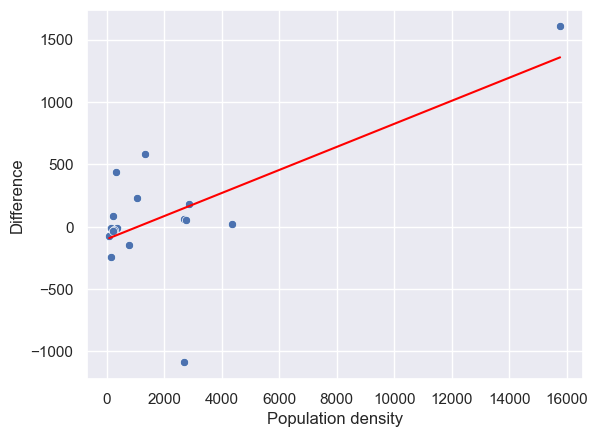

y = 0.0925x + -100.4387

                            OLS Regression Results                            
Dep. Variable:             Difference   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     12.04
Date:                Sun, 25 Jun 2023   Prob (F-statistic):            0.00343
Time:                        22:43:55   Log-Likelihood:                -124.91
No. Observations:                  17   AIC:                             253.8
Df Residuals:                      15   BIC:                             255.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const      

In [146]:
y = df['Difference']
col_list = ['Population', 'Population density']
g_OLS(df, y, col_list)

### LOESS

Population


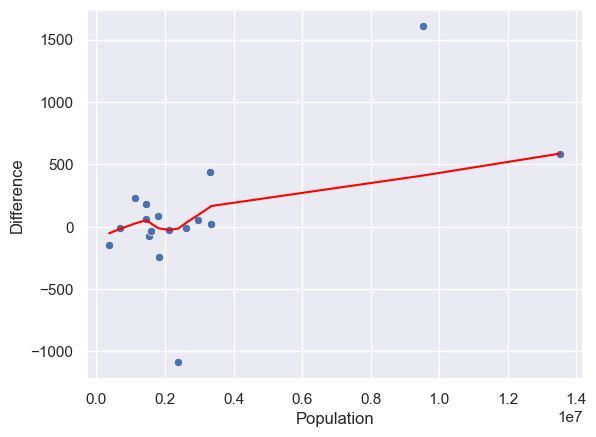

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     243.7
Date:                Sun, 25 Jun 2023   Prob (F-statistic):           1.10e-10
Time:                        22:43:55   Log-Likelihood:                -86.563
No. Observations:                  17   AIC:                             177.1
Df Residuals:                      15   BIC:                             178.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -59.3496     13.859     -4.282      0.0

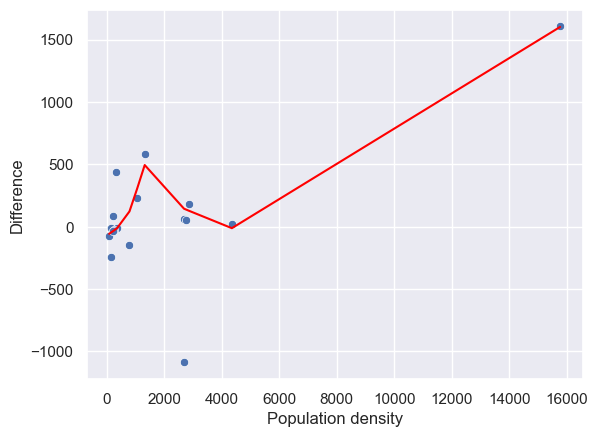

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     73.57
Date:                Sun, 25 Jun 2023   Prob (F-statistic):           3.61e-07
Time:                        22:43:55   Log-Likelihood:                -110.34
No. Observations:                  17   AIC:                             224.7
Df Residuals:                      15   BIC:                             226.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -43.3805     47.647     -0.910      0.3

In [147]:
y = df['Difference']
col_list = ['Population', 'Population density']
g_loess(df, y, col_list)

## down2

In [148]:
df = dic_df['down2']
df.head()

,City,Difference,Population,Area,Population density,Elderly Ratio
0,강원,9331.481784,1539277,16830,91.460309,22.5
1,경기,37336.223230,13527299,10197,1326.595960,14.5
2,경남,14764.959958,3311631,10542,314.136881,19.2
3,경북,48964.638574,2622174,19035,137.755398,23.5
4,광주,2256.934745,1440908,501,2876.063872,15.4


### 정규성 검정

Difference 검정 통계량 : 0.9032566547393799 , Difference p-value : 0.07701842486858368
Difference은 정규성을 만족


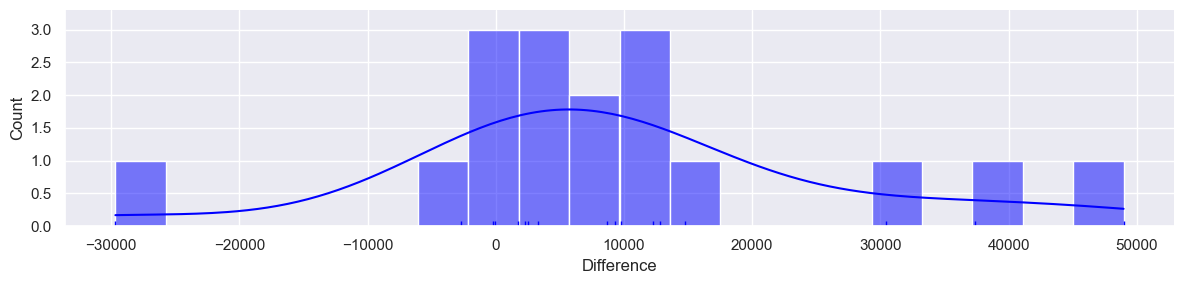

In [149]:
g_shapiro('Difference', df['Difference'])
sns.displot(df['Difference'], color = 'blue', kde = True, rug = True, aspect = 4, height = 3, bins = 20)
plt.show()

## 상관분석

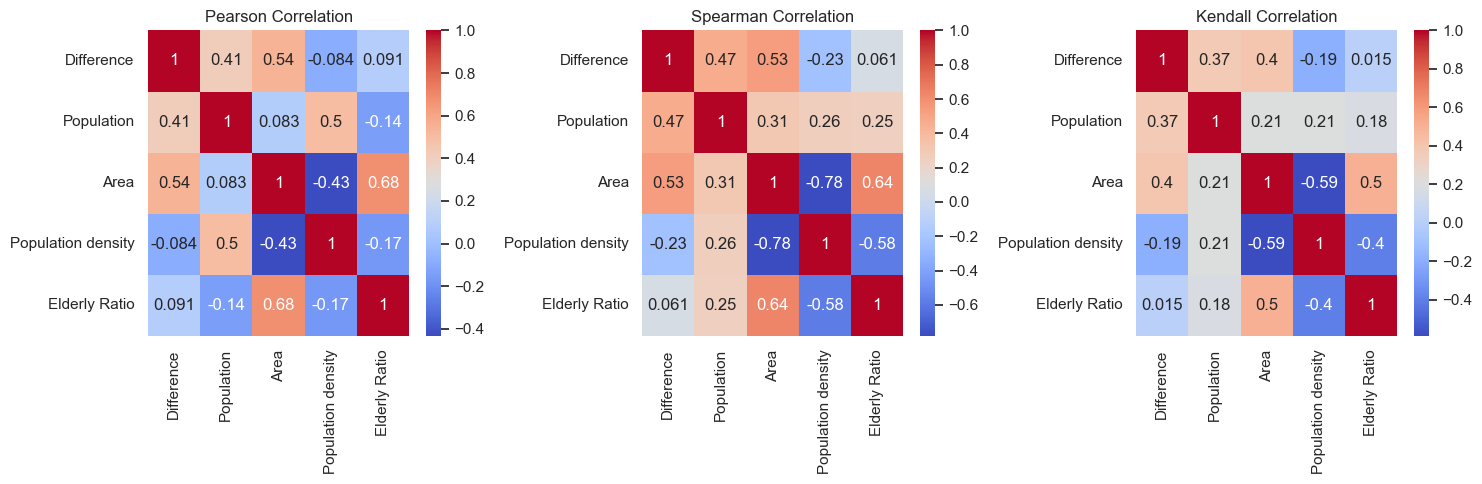

In [150]:
g_corr_heatmap(df)

In [151]:
y = df['Difference']
g_corr(df, y)

Population와 Difference의 상관 분석

    Pearson correlation coefficient: 0.40688133196533743
    p-value: 0.10504652809474883
    귀무가설 채택, 상관계수는 유의하지 않음

    Spearman correlation coefficient: 0.465686274509804
    p-value: 0.05957824210811783
    귀무가설 채택, 상관계수는 유의하지 않음

    Kendall correlation coefficient: 0.3676470588235294
    p-value: 0.04217070212970702
    귀무가설 기각, 상관계수는 유의함

Area와 Difference의 상관 분석

    Pearson correlation coefficient: 0.5437700544389661
    p-value: 0.024052989015953433
    귀무가설 기각, 상관계수는 유의함

    Spearman correlation coefficient: 0.5343137254901961
    p-value: 0.027139775804459705
    귀무가설 기각, 상관계수는 유의함

    Kendall correlation coefficient: 0.39705882352941174
    p-value: 0.027329794647271987
    귀무가설 기각, 상관계수는 유의함

Population density와 Difference의 상관 분석

    Pearson correlation coefficient: -0.0835520281743349
    p-value: 0.7498693130046375
    귀무가설 채택, 상관계수는 유의하지 않음

    Spearman correlation coefficient: -0.22549019607843138
    p-value: 0.38419665076181886
    

## 선형회귀분석

### OLS

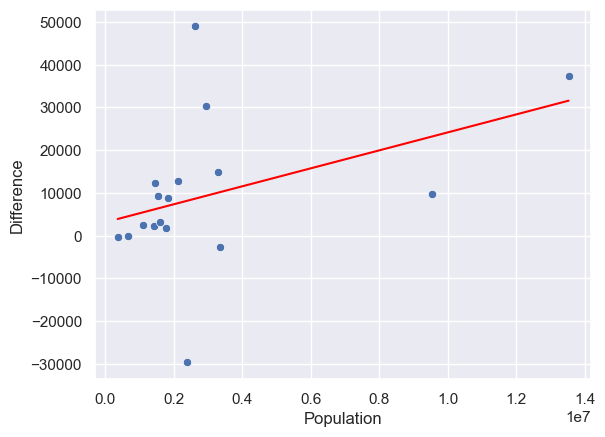

y = 0.0021x + 3101.6758

                            OLS Regression Results                            
Dep. Variable:             Difference   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     2.976
Date:                Sun, 25 Jun 2023   Prob (F-statistic):              0.105
Time:                        22:43:57   Log-Likelihood:                -188.13
No. Observations:                  17   AIC:                             380.3
Df Residuals:                      15   BIC:                             381.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3101.6758   545

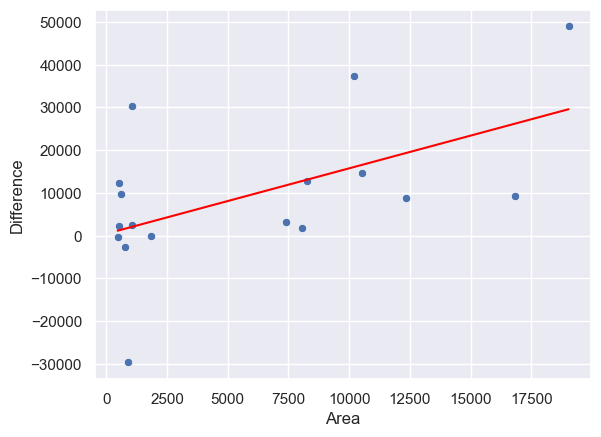

y = 1.5311x + 449.2174

                            OLS Regression Results                            
Dep. Variable:             Difference   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     6.297
Date:                Sun, 25 Jun 2023   Prob (F-statistic):             0.0241
Time:                        22:43:57   Log-Likelihood:                -186.69
No. Observations:                  17   AIC:                             377.4
Df Residuals:                      15   BIC:                             379.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        449.2174   5146

In [152]:
y = df['Difference']
col_list = ['Population', 'Area']
g_OLS(df, y, col_list)

### LOESS

Population


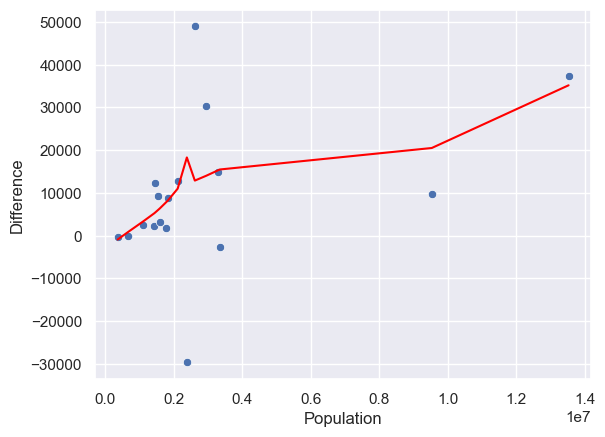

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     62.12
Date:                Sun, 25 Jun 2023   Prob (F-statistic):           1.03e-06
Time:                        22:43:58   Log-Likelihood:                -163.91
No. Observations:                  17   AIC:                             331.8
Df Residuals:                      15   BIC:                             333.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3843.0597   1311.260      2.931      0.0

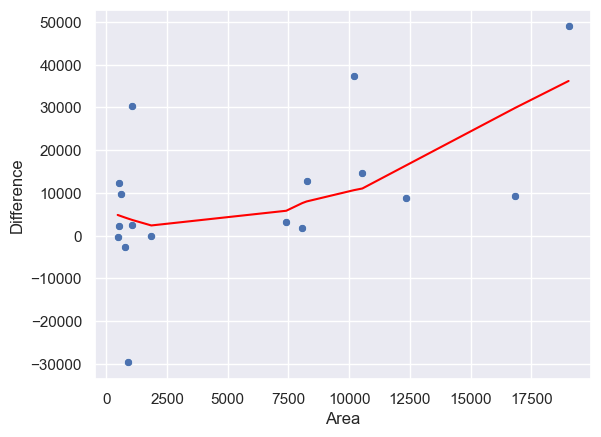

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     67.22
Date:                Sun, 25 Jun 2023   Prob (F-statistic):           6.35e-07
Time:                        22:43:58   Log-Likelihood:                -164.99
No. Observations:                  17   AIC:                             334.0
Df Residuals:                      15   BIC:                             335.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1323.2347   1435.615      0.922      0.3

In [153]:
y = df['Difference']
col_list = ['Population', 'Area']
g_loess(df, y, col_list)

# Explain

"Kernel Regression"과 "Local Polynomial Regression"은 비모수 회귀분석 방법으로 비선형 관계를 모델링하기 위해 사용됩니다. 하지만 두 방법은 약간의 차이가 있습니다. 아래에서 각 방법의 특징을 자세히 설명하겠습니다:

1. Kernel Regression:

- 커널 함수를 사용하여 가중 평균을 계산하고 추세선을 생성합니다.
- 가중치는 커널 함수에 의해 결정되며, 데이터 포인트와의 거리에 따라 가중치가 부여됩니다.
- 주변 데이터의 영향력을 고려하여 예측값을 계산합니다.
- 주변 데이터의 밀도와 데이터 포인트 간의 거리에 따라 모델의 부드러움을 조절할 수 있습니다.
대표적인 예로 LOESS (Locally Weighted Scatterplot Smoothing)가 있습니다.

주어진 데이터에 대한 비모수 회귀분석을 수행하기 위해 LOESS (Locally Weighted Scatterplot Smoothing) 방법을 선택한 이유는 다음과 같습니다:

1. 데이터의 특성:
   - 주어진 데이터는 비모수적인 특성을 가지고 있습니다. 비선형적인 패턴을 가지고 있을 수 있으며, 정규성을 따르지 않을 수 있습니다.
   - LOESS는 비선형적인 관계를 모델링하는 데 적합한 방법 중 하나입니다. 이는 데이터의 비선형성을 잘 캡처하여 모델을 구성할 수 있음을 의미합니다.

2. 데이터의 밀도:
   - 주어진 데이터의 밀도가 균일하지 않을 수 있습니다. 이는 주변 데이터의 밀도가 다를 수 있다는 의미입니다.
   - LOESS는 커널 함수를 사용하여 데이터 포인트 간의 거리에 따라 가중치를 부여하는 방식으로 추세선을 생성합니다. 이를 통해 주변 데이터의 밀도를 고려하여 모델을 구성할 수 있습니다.

3. 모델의 유연성:
   - LOESS는 다항식 회귀보다 더 유연한 모델링을 제공합니다. 추세선의 부드러운 곡선 형태로 데이터에 적합하게 모델링될 수 있습니다.
   - 다항식 회귀에 비해 고차항을 선택하는 번거로움 없이 데이터의 패턴에 적합한 추세선을 얻을 수 있습니다.

따라서, 주어진 비모수 데이터에 대한 비모수 회귀분석에서 LOESS 방법을 선택한 이유는 데이터의 비선형성, 밀도의 비균일성, 그리고 모델의 유연성을 고려하여 데이터에 적합한 추세선을 생성하기 위함입니다.